# Avaliação 1
Consideração o modelo de previsão de demanda, realizar a análise dos seguintes itens:

1. Modificar as funções de ativação utilizando Relu, Sigmod, tanh, etc. Analisar o desempenho da RNA.

2. Modificar o número de camadas ocultas e neurônios (Sintonização da melhor rede) https://wandb.ai/site

3. Realizar um estudo sobre o otimizador “Adam”

4. Na fase de teste, avaliar as métricas de:
  a. Erro Relativo Absoluto
  b. MAPE
  c. Máximo Erro Relativo Absoluto

5. Realizar a Previsão diária considerando um dia para frente e sete dias para atrás, com a finalidade de encontrar a melhor rede com ERA<10% e MAPE<3%. Utilize a 'Normalização' e faça a 'desnormalização' para mostrar os valores da previsão da potência.

# Importação das Bibliotecas

Aqui, importa-se as seguintes bibliotecas:
1. tensorflow - 
2. pandas - 
3. numpy - 
4. matplotlib.pyplot - 



In [116]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

# Leitura e Ajuste dos Dados

In [117]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
df = pd.read_csv('/content/drive/MyDrive/DESENVOLVIMENTO PESSOAL/MESTRADO/TÉCNICAS APLICADAS DE INTELIGÊNCIA ARTIFICIAL/Exemplo Previsão de Demanda/Parte 1 - Atualizado/dados_demanda.csv',delimiter=';')
df.dropna(axis=1,inplace=True)

df['TEMPO'] = df[['DIA','MES','ANO','HORA','MINUTO']].apply(lambda x : datetime(year=x[2],month=x[1],day=x[0],hour=x[3],minute=x[4]), axis=1)
df.drop(['MINUTO','HORA','ANO','DIA','MES'],axis=1,inplace=True)
df.rename(columns={'JPS_12B1':'POTENCIA'},inplace=True)
df['POTENCIA']=df['POTENCIA'].str.replace(',', '.').astype(float)
df.set_index('TEMPO',inplace=True)

In [142]:
maxima_semanal=df.resample('W').agg(['max'])

In [143]:
dias_tras = 7
dias_frente = 1

In [144]:
data = pd.DataFrame()
data['POTÊNCIA'] = maxima_semanal

for i in range(1,dias_tras+1):
  data['POTÊNCIA(K-'+str(i)+')'] = maxima_semanal.shift(i)



for i in range(1,dias_frente+1):
  data['POTÊNCIA(K+'+str(i)+')'] = maxima_semanal.shift(-i)

In [145]:
data.dropna(axis=0, inplace=True)
dataMax = data

In [172]:
np.array(maxima_semanal.agg(['max']))[0][0]

24.1000003814697

In [124]:
fator_treino = 0.72
data_dim, len_data = data.shape #Pega a quantidade de dados. O segundo termo não é necessário, pois já se sabe a quantidade de colunas de treinamento e de saída. 
data_treino_dim = data_dim*fator_treino

len_train = dias_tras+1 #Número de colunas usadas para treino

# LEITURA E ADEQUAMENTO DOS DADOS

In [125]:

data = np.array(data)
data = tf.keras.utils.normalize(data,axis=1)

x_train = data[0:216,0:len_train]
y_train = data[0:216,len_train:len_data]

x_test = data[216:308,0:len_train]
y_test = data[216:308,len_train:len_data]

In [126]:
data.shape

(306, 9)

# CRIAÇÃO E TREINAMENTO DA REDE

In [127]:
funcoes = [tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh, tf.nn.softmax]
medicoes = dict()
val_loss = dict()
val_mse = dict()

for funcao in funcoes:

  # Criando Rede
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(8))




  for i in [20,20,1]:
    model.add(tf.keras.layers.Dense(i,activation=funcao))

  # Parâmetros de treinamento
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics = ['mean_squared_error'])

  # Treinando 
  model.fit(x_train,y_train,epochs=500)
  val_loss[funcao], val_mse[funcao] = model.evaluate(x_test,y_test)


Epoch 1/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 2/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 3/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 4/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 5/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 6/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 7/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 8/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 9/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 10/500
7/7 [===================

In [128]:
melhor_funcao = list(val_mse.keys()) [list(val_mse.values()).index(min(val_mse.values()))]
melhor_funcao


<function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>

In [129]:
val_loss

{<function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>: 0.11010235548019409,
 <function tensorflow.python.ops.math_ops.sigmoid(x, name=None)>: 0.00032279107836075127,
 <function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>: 0.0002675064606592059,
 <function tensorflow.python.ops.nn_ops.softmax_v2(logits, axis=None, name=None)>: 0.4476436972618103}

In [130]:
# Avaliacao numero de camadas e quantidade de neuronios
def camadas_e_neuronios(dados):
  camadas = [
      [20,20,1],
      [10,10,1]
  ]

  return camadas[0]

camadas_e_neuronios(2)

[20, 20, 1]

In [131]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(8))
for i in [20,20,1]:
  model.add(tf.keras.layers.Dense(i,activation=melhor_funcao))

# Parâmetros de treinamento
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics = ['mean_squared_error'])

# Treinando 
model.fit(x_train,y_train,epochs=5000)
loss, mse = model.evaluate(x_test,y_test)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 2502/5000
7/7 [==============================] - 0s 5ms/step - loss: 1.1904e-05 - mean_squared_error: 1.1904e-05
Epoch 2503/5000
7/7 [==============================] - 0s 4ms/step - loss: 1.3030e-05 - mean_squared_error: 1.3030e-05
Epoch 2504/5000
7/7 [==============================] - 0s 4ms/step - loss: 1.9407e-05 - mean_squared_error: 1.9407e-05
Epoch 2505/5000
7/7 [==============================] - 0s 4ms/step - loss: 1.7215e-05 - mean_squared_error: 1.7215e-05
Epoch 2506/5000
7/7 [==============================] - 0s 4ms/step - loss: 3.5320e-05 - mean_squared_error: 3.5320e-05
Epoch 2507/5000
7/7 [==============================] - 0s 5ms/step - loss: 2.1221e-05 - mean_squared_error: 2.1221e-05
Epoch 2508/5000
7/7 [==============================] - 0s 4ms/step - loss: 1.3341e-05 - mean_squared_error: 1.3341e-05
Epoch 2509/5000
7/7 [==============================] - 0s 4ms/step - loss: 1.0428e-05 - mean_squared_error: 

In [132]:
melhor_funcao

<function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>

# VALIDAÇÃO

In [174]:
maximo = np.array(maxima_semanal.agg(['max']))[0][0]

3/3 [==============================] - 0s 5ms/step - loss: 4.7131e-06 - mean_squared_error: 4.7131e-06


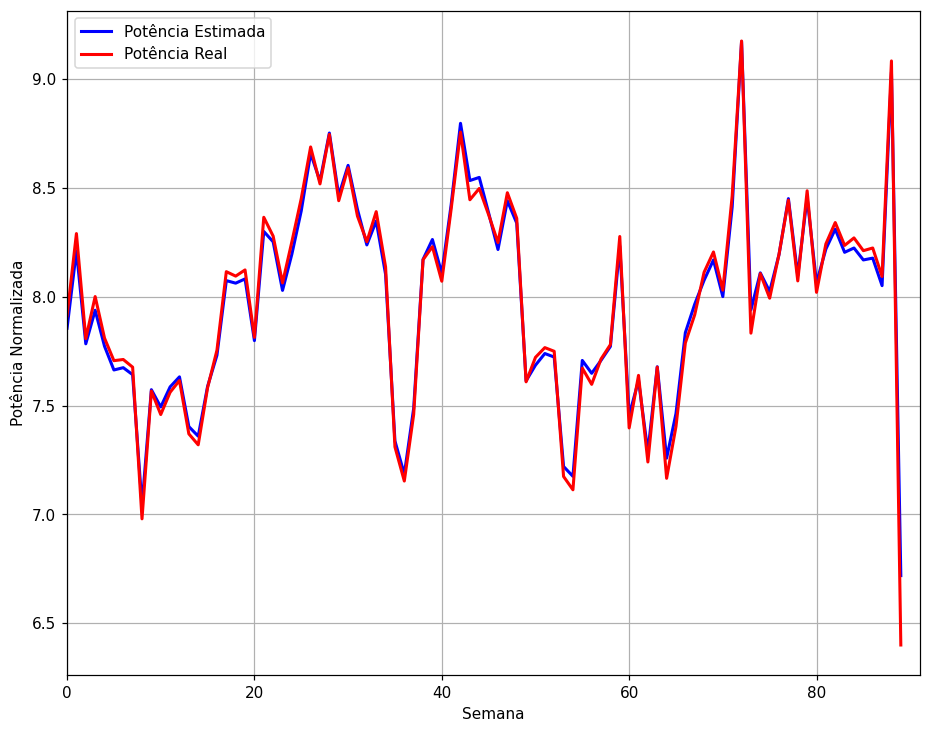

In [176]:
val_loss, val_mse = model.evaluate(x_test,y_test)
y_pred = model.predict(x_test)

plt.figure(figsize=(10,8),dpi=110)
plt.plot(y_pred[:,0]*maximo,lw=2,color='Blue')
plt.plot(y_test[:,0]*maximo,lw=2,color='Red')
plt.grid(True)
plt.xlim([0,91])
plt.xlabel('Semana')
plt.ylabel('Potência Normalizada')
plt.legend(['Potência Estimada','Potência Real']) 

In [135]:
val_mse

4.713080670626368e-06

# DEMAIS VALIDAÇÕES

#Questão 4
Na fase de teste, avaliar as métricas de: 
 

1.   Erro Relativo Absoluto
2.   MAPE 
3.   Máximo Erro Relativo Absoluto


In [136]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [137]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
MAPE 
#val_loss, val_mse = model.evaluate(x_test,y_test)
#y_pred = model.predict(x_test)

0.004883945982324979

In [138]:
y_test.shape

(90, 1)

In [139]:
y_pred.shape

(90, 1)

In [140]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

0.0015727203207144325